In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#read raw data
df = pd.read_csv('dataset.csv')

if df.isnull().values.any():
    print ('missing values!')
    #raise ValueError
else:
    print('pass')

df.head()

pass


,MolID,wt_A1,pore/wt_A1,D3/wt_A1,D3-pore/wt_A1,target_permeator,BalabanJ,BertzCT,Chi0,Chi1,...,PMI3,RadiusOfGyration,SpherocityIndex,avg_asphericity,avg_acylindricity,avg_kappa2,avg_rg,avg_largest_principal_rg,avg_middle_principal_rg,avg_smallest_principal_rg
0,1500272,0.875560,1.000000,1.834508,1.372092,0,1.429,1053.463,24.526,17.092,...,8960.40,4.71,0.26,0.377154,0.212826,0.287922,0.526401,0.505270,0.457168,0.299362
1,1501007,1.152989,1.061628,1.943367,1.755086,0,1.868,592.306,16.113,10.436,...,5322.33,4.43,0.13,0.310194,0.123611,0.349557,0.411174,0.391925,0.369452,0.216417
2,1501150,2.930928,1.000000,1.297877,1.143172,1,2.143,675.300,17.035,10.863,...,4454.32,3.82,0.13,0.307322,0.156884,0.302154,0.421545,0.403439,0.370261,0.235260
3,1503100,10.334869,1.000000,1.193855,1.049448,1,1.453,912.788,20.096,13.507,...,6975.32,4.50,0.21,0.402013,0.129149,0.435131,0.498724,0.478465,0.459285,0.236546
4,1503243,8.064048,1.000000,1.522722,1.344302,0,1.847,673.567,17.527,11.469,...,6455.60,4.67,0.11,0.365638,0.124397,0.441792,0.454138,0.437384,0.416621,0.212002


In [2]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve,plot_roc_curve)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, LeaveOneOut, ParameterGrid, cross_val_predict

RF_param_grid = {"n_estimators" : [100, 200, 400, 600, 1000],
                 "min_samples_leaf" : [1,2,4],
                 "max_features" : [None,'sqrt','log2']}

RF = RandomForestClassifier(random_state=0)

In [36]:
def grid_search_loocv(X, y, estimator, sampler, param_grid):
    from operator import itemgetter

    cv = LeaveOneOut()
    param_combinations = ParameterGrid(param_grid)
    result_list = []
    Y_pred = np.array([])
    metric_cols=['F1','precision','recall','accuracy','confusion_matrix']
    
    # evaluate model

    for param in param_combinations:
        model = Pipeline([('over-sampling', sampler), ('clf', estimator.set_params(**param))])
        Y_pred = cross_val_predict(estimator, X, Y, cv=cv, n_jobs=-1)
        #print(score)
        f1 = round(f1_score(y,Y_pred),3)
        prec = round(precision_score(y,Y_pred),3)
        recall = round(recall_score(y,Y_pred),3)
        acc = round(accuracy_score(y,Y_pred),3)
        conf = confusion_matrix(y,Y_pred).tolist()
        result_list.append((f1, prec, recall, acc, conf, param))

    top_param = max(result_list,key=itemgetter(3)) # rank by accuracy
    print(f"tuned parameteres:{top_param}\n") # best parameters combination
    print("---all combinations with score metrics---")
    print('\t'.join(metric_cols+list(param.keys()))) # title row
    for result in result_list:
        print(result)

    # re-produce the result with best param
    print("---leave one out validation with best parameter set---")
    model = Pipeline([('over-sampling', sampler), ('clf', estimator.set_params(**top_param[-1]))])
    pred_probs = cross_val_predict(model, X, Yb, cv=cv, n_jobs=-1, method='predict_proba')
    Y_pred = pred_probs.argmax(axis=1)
    fpr, tpr, _ = roc_curve(Yb,pred_probs[:,1])
    plt.plot(fpr, tpr)
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    f1 = round(f1_score(Yb,Y_pred),3)
    prec = round(precision_score(Yb,Y_pred),3)
    recall = round(recall_score(Yb,Y_pred),3)
    acc = round(accuracy_score(Yb,Y_pred),3)
    AUC = round(roc_auc_score(Yb, pred_probs[:,1]),3)
    conM = confusion_matrix(Yb,Y_pred).tolist()
    metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))
    return

### target_permeator ###
#positive/negative: 20/63
tuned parameteres:(0.424, 0.538, 0.35, 0.771, [[57, 6], [13, 7]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100})

---all combinations with score metrics---
F1	precision	recall	accuracy	confusion_matrix	max_features	min_samples_leaf	n_estimators
(0.424, 0.538, 0.35, 0.771, [[57, 6], [13, 7]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100})
(0.375, 0.5, 0.3, 0.759, [[57, 6], [14, 6]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200})
(0.375, 0.5, 0.3, 0.759, [[57, 6], [14, 6]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400})
(0.387, 0.545, 0.3, 0.771, [[58, 5], [14, 6]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 600})
(0.387, 0.545, 0.3, 0.771, [[58, 5], [14, 6]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 1000})
(0.387, 0.545, 0.3, 0.771, [[58, 5], [14, 6]], {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 1

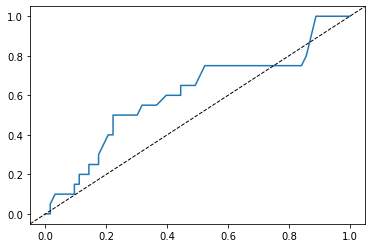

In [35]:
Ycolumn = 'target_permeator'
descriptors = ['PMI1','avg_smallest_principal_rg','NumHDonors','TPSA','avg_kappa2','avg_rg','Kappa3','NumRotatableBonds','HallKierAlpha','FpDensityMorgan2','NumHAcceptors','NumHeteroatoms','LabuteASA','NumAromaticCarbocycles','NumAromaticRings','NPR2','EState_VSA2','MaxAbsEStateIndex','NumAliphaticHeterocycles','FractionCSP3','NumAliphaticCarbocycles','MinAbsEStateIndex','MinPartialCharge','NumAromaticHeterocycles','NPR1','MaxAbsPartialCharge','MinEStateIndex','avg_acylindricity','MinAbsPartialCharge','MolLogP'] # Features after clustering

print(f"### {Ycolumn} ###")
### specify X and Y ###
Y = df[Ycolumn]
X_raw = df.iloc[:,6:]

if Y.isnull().values.any():
    print("Warning: NaN found")

X = StandardScaler().fit_transform(X_raw[descriptors])
Yb = Y.to_numpy()

print(f"#positive/negative: {sum(Yb)}/{len(Yb)-sum(Yb)}")

#resampling = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=11), cluster_balance_threshold=1,  n_jobs=-1, random_state=42)
#RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=9), k_neighbors=2, cluster_balance_threshold=0.2, n_jobs=-1, random_state=0)
#sampler = ADASYN()

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=0)
#accuracy balanced_accuracy top_k_accuracy average_precision f1 precision recall jaccard roc_auc
#gs = GridSearchCV(model, param_grid = RF_param_grid, cv = cv, refit=True, scoring="balanced_accuracy", n_jobs=-1, error_score=0, verbose=0)
#gs.fit(X_given, Yb)

# print("\t#RF_tuned_params =", gs.best_params_)
# print("\t#Best score:", gs.best_score_)
# means = gs.cv_results_['mean_test_score']
# stds = gs.cv_results_['std_test_score']
# params = gs.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f"{mean} ({stdev}) with: {param}")

grid_search_loocv(X, Yb, RF, sampler, RF_param_grid)

## leave one out

In [28]:
#sampler = KMeansSMOTE(kmeans_estimator=9, k_neighbors=2, cluster_balance_threshold=0.2)
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, max_features=None, random_state=0, bootstrap=True)
model = Pipeline([('over-sampling', sampler), ('clf', clf)])

# leave one out
cv = LeaveOneOut()
#f1 = prec = recall = acc = AUC = conM = []
for i in range(10):
    #Y_pred = cross_val_predict(model, X, Yb, cv=cv, n_jobs=-1)
    pred_probs = cross_val_predict(model, X, Yb, cv=cv, n_jobs=-1, method='predict_proba')
    Y_pred = pred_probs.argmax(axis=1)
    fpr, tpr, _ = roc_curve(Yb,pred_probs[:,1])
    # plt.plot(fpr, tpr)
    # plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    # evaluate model
    f1 = round(f1_score(Yb,Y_pred),3)
    prec = round(precision_score(Yb,Y_pred),3)
    recall = round(recall_score(Yb,Y_pred),3)
    acc = round(accuracy_score(Yb,Y_pred),3)
    AUC = round(roc_auc_score(Yb, pred_probs[:,1]),3)
    conM = confusion_matrix(Yb,Y_pred).tolist()
    metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))

      F1  precision  recall  accuracy  AUROC     confusion_matrix
0  0.333      0.375     0.3     0.711   0.59  [[53, 10], [14, 6]]
      F1  precision  recall  accuracy  AUROC     confusion_matrix
0  0.333      0.375     0.3     0.711  0.591  [[53, 10], [14, 6]]
      F1  precision  recall  accuracy  AUROC    confusion_matrix
0  0.353      0.429     0.3     0.735  0.598  [[55, 8], [14, 6]]
      F1  precision  recall  accuracy  AUROC    confusion_matrix
0  0.432      0.471     0.4     0.747  0.673  [[54, 9], [12, 8]]
      F1  precision  recall  accuracy  AUROC     confusion_matrix
0  0.368      0.389    0.35     0.711   0.57  [[52, 11], [13, 7]]
     F1  precision  recall  accuracy  AUROC     confusion_matrix
0  0.39      0.381     0.4     0.699  0.585  [[50, 13], [12, 8]]
      F1  precision  recall  accuracy  AUROC    confusion_matrix
0  0.343        0.4     0.3     0.723  0.602  [[54, 9], [14, 6]]
      F1  precision  recall  accuracy  AUROC    confusion_matrix
0  0.294      0.357

## 5-fold cross-validation

     F1  precision  recall  accuracy  AUROC     confusion_matrix
0  0.45       0.45    0.45     0.735  0.659  [[52, 11], [11, 9]]


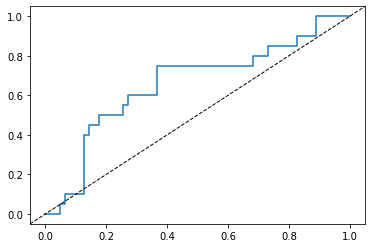

In [24]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
#metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']

pred_probs = cross_val_predict(model, X, Yb, cv=cv, n_jobs=-1, method='predict_proba')
Y_pred = pred_probs.argmax(axis=1)
#print(pred_test_probs)
fpr, tpr, _ = roc_curve(Yb,pred_probs[:,1]) # use pred_test_probs instead of pred_test

f1 = round(f1_score(Yb,Y_pred),3)
prec = round(precision_score(Yb,Y_pred),3)
recall = round(recall_score(Yb,Y_pred),3)
acc = round(accuracy_score(Yb,Y_pred),3)
AUC = round(roc_auc_score(Yb, pred_probs[:,1]),3)
conM = confusion_matrix(Yb,Y_pred).tolist()
metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))

plt.plot(fpr, tpr)
plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
# i += 1 # plot ROC curve

# 
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.legend()
# plt.title(FigureTitel)
# plt.show()
#return a dataframe consisting five metrics and confusion matrix.

In [ ]:
### wt_A1 ###
#positive/negative: 21/62

---RandomOverSampler---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 160}
	#Best score: 0.6279411764705882

---SMOTE---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 1280}
	#Best score: 0.661764705882353

---BorderlineSMOTE---
	#RF_tuned_params = {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__n_estimators': 320}
	#Best score: 0.6507352941176471

---SVMSMOTE---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 160}
	#Best score: 0.7117647058823529

---ADASYN---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 160}
	#Best score: 0.6507352941176471

### target_permeator ###
#positive/negative: 20/63

---RandomOverSampler---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 480}
	#Best score: 0.725

---SMOTE---
	#RF_tuned_params = {'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 640}
	#Best score: 0.6757352941176471

---BorderlineSMOTE---
	#RF_tuned_params = {'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 960}
	#Best score: 0.6764705882352942

---SVMSMOTE---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 640}
	#Best score: 0.7367647058823529

---ADASYN---
	#RF_tuned_params = {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__n_estimators': 960}
	#Best score: 0.6757352941176471